In [1]:
import ROOT as rt
import uproot
import numpy as np
from collections import OrderedDict
import csv
import os
import math
import sys
sys.path.append("/uscms/home/christiw/nobackup/CMSSW_11_3_4/src/MDS_CMSDAS2023/lib")

import importlib
import helper
importlib.reload(sys.modules['helper'])
from helper import  weight_calc, make_datacard

import tdrstyle
a = tdrstyle.setTDRStyle()

print(sys.version)

Welcome to JupyROOT 6.28/00
3.9.12 (main, Jun  7 2022, 16:09:12) 
[GCC 11.2.0]


In [11]:
std_color_list = [1,2,4,6,8] #choose your favorite color in ROOT

# Load ntuples

In [29]:
fpath =OrderedDict()
tree = OrderedDict()

prod =['ggH']
decay = 'bbbb'



mass = [40]

OLD_CTAU = np.array([1000, 10000, 100000])#in mm



path = '/uscms/home/christiw/nobackup/CMSSW_11_3_4/src/MDS_CMSDAS2023/ntuples/'

fpath['data'] = path + 'Run2_displacedJetMuonNtupler_V1p17_Data2018_17Sept2018_Run2018B-HighMET-17Sep2018_Job9_of_20.root'



for m in mass:
    for ct in OLD_CTAU:
        key = 'MC_'+str(m)+'_'+str(ct)                       
        fpath[key] = path +  'ggH_HToSSTobbbb_MH-125_MS-40_ctau-'+str(ct)+'_137000pb_weighted.root'

# fpath['hnl']= '/storage/af/user/christiw/HNL_electronType_ms5p0_plVe2_1e-5/HeavyNeutralLepton_Tree.root'                        
NEvents = {}
NEvents_genweight = {}
for k,v in fpath.items():
    root_dir = uproot.open(v) 
    if not root_dir: 
        print(k, "zombie")
        continue
    tree[k] = root_dir['MuonSystem']


# Selections

In [30]:
deltaPhi = {}
Nhits = {}
weight = {}
gLLP_ctau = {}
cscRechitClusterJetVeto = {}
cscRechitClusterMuonVeto = {}
cscRechitClusterTimeSpread = {}
cscRechitClusterTime = {}
cscRechitClusterEta = {}
cscRechitClusterMe11 = {}
cscRechitClusterMe12 = {}

for k, T in tree.items():
    
    ########### SELECTION: CLUSTERS ############
    if 'data' in k:sel_clusters = T['cscRechitClusterSize'].array() > 0
    else: sel_clusters = np.logical_and(T['cscRechitCluster_match_gLLP'].array(), T['cscRechitCluster_match_gLLP_csc'].array())

    ########### SELECTION: JETS ############

    sel_jet = np.logical_and(T['jetPt'].array() > 30, np.abs(T['jetEta'].array()) < 2.4 )
    sel_jet = np.logical_and(sel_jet, T['jetTightPassId'].array())

    ########### SELECTION: EVENTS ############
    # select only triggered events
    sel_ev = T['METNoMuTrigger'].array()

    sel_ev  = np.logical_and(sel_ev,np.sum(sel_clusters, axis = 1)>0)
    sel_ev = np.logical_and(sel_ev ,T['metEENoise'].array() > 200)
    sel_ev = np.logical_and(sel_ev , np.sum(sel_jet,axis=1)>=1)
    sel_ev = np.logical_and(sel_ev,T['Flag2_all'].array())

    #### Save variables needed for ABCD ####                                   

    deltaPhi[k] = T['cscRechitClusterMetEENoise_dPhi'].array()[sel_clusters][sel_ev][:,0]
    Nhits[k] = T['cscRechitClusterSize'].array()[sel_clusters][sel_ev][:,0]
    cscRechitClusterJetVeto[k] = T['cscRechitClusterJetVetoPt'].array()[sel_clusters][sel_ev][:,0]
    cscRechitClusterMuonVeto[k] = T['cscRechitClusterMuonVetoPt'].array()[sel_clusters][sel_ev][:,0]
    cscRechitClusterTime[k] = T['cscRechitClusterTimeWeighted'].array()[sel_clusters][sel_ev][:,0]
    cscRechitClusterEta[k] = T['cscRechitClusterEta'].array()[sel_clusters][sel_ev][:,0]
    cscRechitClusterMe11[k] = (T['cscRechitClusterNRechitChamberPlus11'].array() + T['cscRechitClusterNRechitChamberMinus11'].array())[sel_clusters][sel_ev][:,0]
    cscRechitClusterMe12[k] = (T['cscRechitClusterNRechitChamberPlus12'].array() + T['cscRechitClusterNRechitChamberMinus12'].array())[sel_clusters][sel_ev][:,0]

    weight[k] = T['weight'].array()[sel_ev]
#                  *T.array('pileupWeight')*T.array('metSF'))[sel_ev][bdt_sel]
    gLLP_ctau[k] = T['gLLP_ctau'].array()[sel_ev]
    print(k, np.sum(weight[k]))

data 1539.0
MC_40_1000 8391.234
MC_40_10000 5881.3994
MC_40_100000 804.09265


# EX1-plot jet veto and muon veto

data 0.350227420402859
MC_40_1000 0.8002997809293209
MC_40_10000 0.866107436683336
MC_40_100000 0.8695652173913043


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


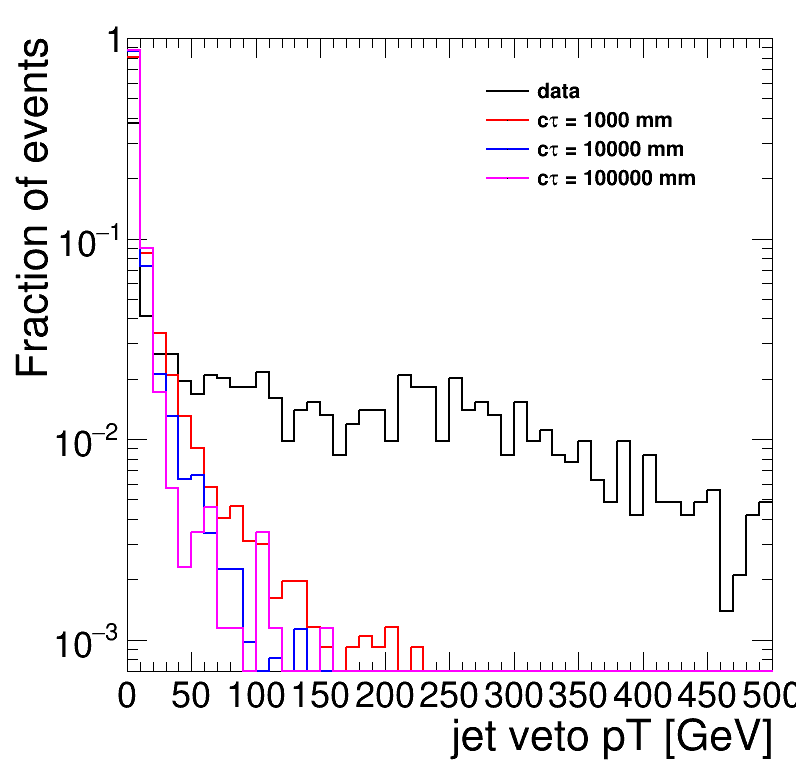

In [31]:

leg = rt.TLegend(0.6,0.75,0.90,0.90)
leg.SetTextSize(0.03)
leg.SetBorderSize(0)
leg.SetEntrySeparation(0.01)
c = rt.TCanvas('c','c', 800, 800)
rt.gStyle.SetOptFit(1011)
h = {}
for i, k in enumerate(tree.keys()):
    
    h[k] = rt.TH1D('', '', 50, 0, 500)
    h[k].SetXTitle('jet veto pT [GeV]')
    h[k].SetYTitle('Fraction of events')
    for j in range(len(cscRechitClusterJetVeto[k])): h[k].Fill(cscRechitClusterJetVeto[k][j])

    # calculate the efficiency of the cuts  
    print(k, np.count_nonzero(cscRechitClusterJetVeto[k]<10)/len(cscRechitClusterJetVeto[k]))
    
    h[k].SetLineColor(std_color_list[i])
    h[k].Scale(1./h[k].Integral())
    h[k].SetMaximum(1)
    if k == 'data':leg.AddEntry(h[k],k)
    else: leg.AddEntry(h[k],'c#tau = {} mm'.format(k.split('_')[-1]))
    h[k].Draw('hist same')
leg.Draw()
c.SetLogy()
c.SetRightMargin(0.03)
c.Draw()

# EX2-plot number of ME11 and ME12 hits in the cluster

data 0.21377517868745938
MC_40_1000 0.7802375187363081
MC_40_10000 0.8522342313276335
MC_40_100000 0.8546910755148741


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


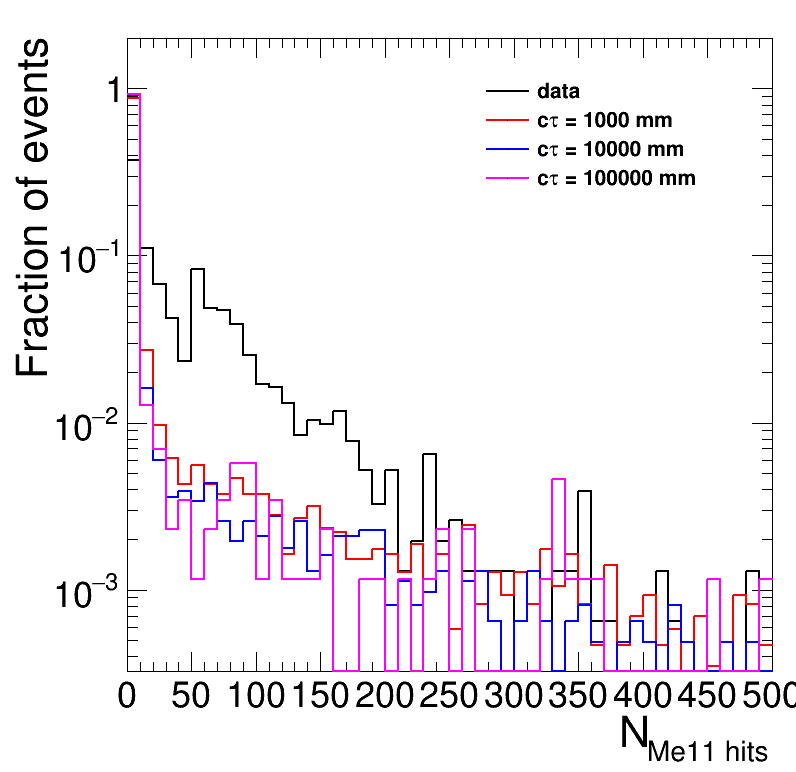

In [32]:

leg = rt.TLegend(0.6,0.75,0.90,0.90)
leg.SetTextSize(0.03)
leg.SetBorderSize(0)
leg.SetEntrySeparation(0.01)
c = rt.TCanvas('c','c', 800, 800)
rt.gStyle.SetOptFit(1011)
h = {}
for i, k in enumerate(tree.keys()):
    
    h[k] = rt.TH1D('', '', 50, 0, 500)
    h[k].SetXTitle('N_{Me11 hits}')
    h[k].SetYTitle('Fraction of events')
    for j in range(len(cscRechitClusterMe11[k])): h[k].Fill(cscRechitClusterMe11[k][j])

    # calculate the efficiency of the cuts  
    print(k, np.count_nonzero(cscRechitClusterMe11[k]==0)/len(cscRechitClusterMe11[k]))
    
    h[k].SetLineColor(std_color_list[i])
    h[k].Scale(1./h[k].Integral())
    h[k].SetMaximum(2)
    if k == 'data':leg.AddEntry(h[k],k)
    else: leg.AddEntry(h[k],'c#tau = {} mm'.format(k.split('_')[-1]))
    h[k].Draw('hist same')
leg.Draw()
c.SetLogy()
c.SetRightMargin(0.03)
c.Draw()

# EX3 - plot cluster eta

data 0.5380116959064327
MC_40_1000 0.8732849071832123
MC_40_10000 0.9122439103081142
MC_40_100000 0.9210526315789473


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


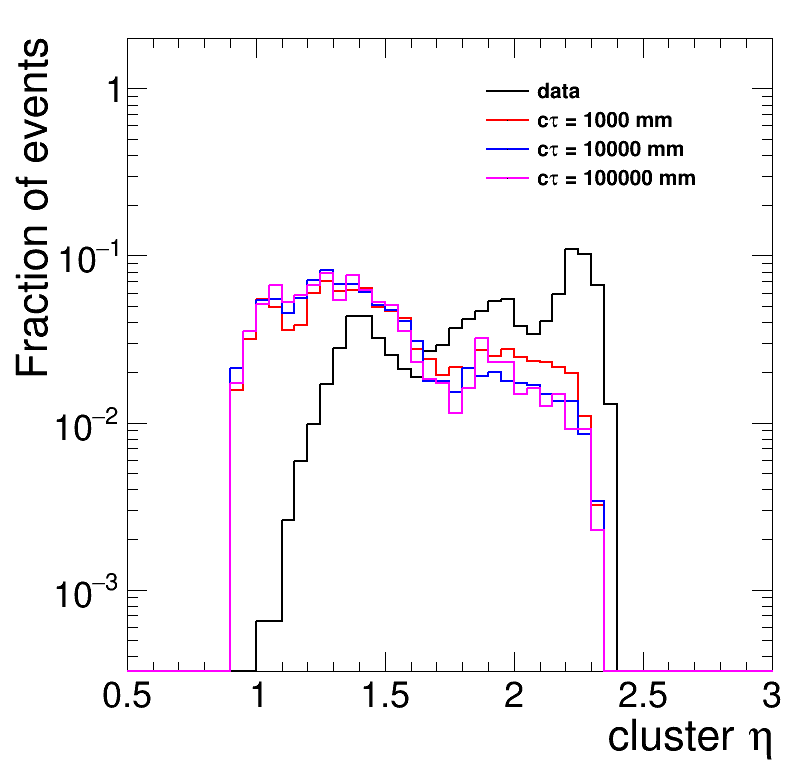

In [33]:

leg = rt.TLegend(0.6,0.75,0.90,0.90)
leg.SetTextSize(0.03)
leg.SetBorderSize(0)
leg.SetEntrySeparation(0.01)
c = rt.TCanvas('c','c', 800, 800)
rt.gStyle.SetOptFit(1011)
h = {}
for i, k in enumerate(tree.keys()):
    
    h[k] = rt.TH1D('', '', 50, 0.5, 3)
    h[k].SetXTitle('cluster #eta')
    h[k].SetYTitle('Fraction of events')
    for j in range(len(cscRechitClusterEta[k])): h[k].Fill(abs(cscRechitClusterEta[k][j]))

    # calculate the efficiency of the cuts  
    print(k, np.count_nonzero(np.abs(cscRechitClusterEta[k])<2)/len(cscRechitClusterEta[k]))
    
    h[k].SetLineColor(std_color_list[i])
    h[k].Scale(1./h[k].Integral())
    h[k].SetMaximum(2)
    if k == 'data':leg.AddEntry(h[k],k)
    else: leg.AddEntry(h[k],'c#tau = {} mm'.format(k.split('_')[-1]))
    h[k].Draw('hist same')
leg.Draw()
c.SetLogy()
c.SetRightMargin(0.03)
c.Draw()

# EX4 - plot cluster time (after vetos are applied)

data 0.23717948717948717
MC_40_1000 0.9998219373219374
MC_40_10000 0.9689333043667173
MC_40_100000 0.9192073170731707


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


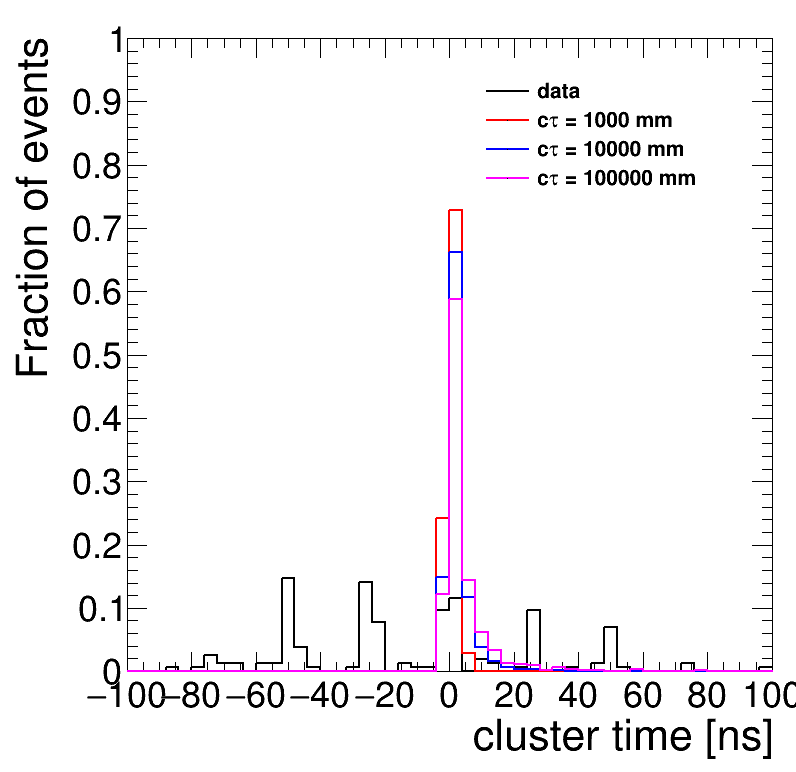

In [38]:

leg = rt.TLegend(0.6,0.75,0.90,0.90)
leg.SetTextSize(0.03)
leg.SetBorderSize(0)
leg.SetEntrySeparation(0.01)
c = rt.TCanvas('c','c', 800, 800)
rt.gStyle.SetOptFit(1011)
h = {}
for i, k in enumerate(tree.keys()):
    
    h[k] = rt.TH1D('', '', 50, -100, 100)
    h[k].SetXTitle('cluster time [ns]')
    h[k].SetYTitle('Fraction of events')
    
    sel = np.logical_and(cscRechitClusterJetVeto[k]<10, cscRechitClusterMuonVeto[k]<20)
    sel = np.logical_and(sel, np.abs(cscRechitClusterEta[k])<2)
    for j in range(len(cscRechitClusterTime[k][sel])): h[k].Fill(cscRechitClusterTime[k][sel][j])

    # calculate the efficiency of the cuts  
    print(k, np.count_nonzero(np.logical_and(cscRechitClusterTime[k][sel]<12.5, cscRechitClusterTime[k][sel]>-5))/len(cscRechitClusterTime[k][sel]))
    
    h[k].SetLineColor(std_color_list[i])
    h[k].Scale(1./h[k].Integral())
    h[k].SetMaximum(1)
    if k == 'data':leg.AddEntry(h[k],k)
    else: leg.AddEntry(h[k],'c#tau = {} mm'.format(k.split('_')[-1]))
    h[k].Draw('hist same')

leg.Draw()
c.SetRightMargin(0.03)
c.Draw()

# EX4-plot deltaPhi and Nhits in Out-of-time Validation Region (final discriminating variables)

data 0.0375
MC_40_1000 0.8823005698005698
MC_40_10000 0.8138170758201173
MC_40_100000 0.7820121951219512


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


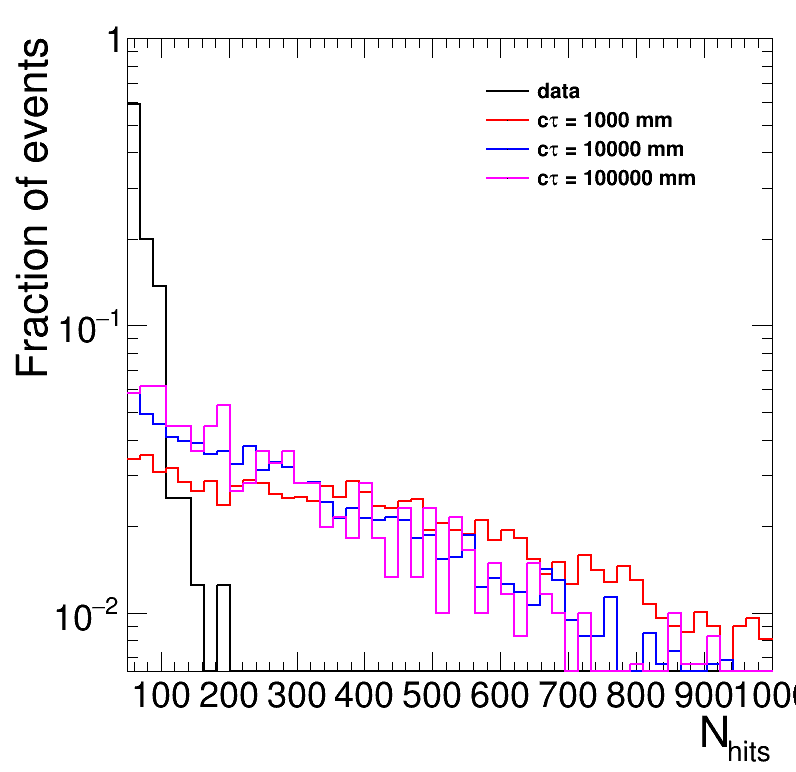

In [43]:

leg = rt.TLegend(0.6,0.75,0.90,0.90)
leg.SetTextSize(0.03)
leg.SetBorderSize(0)
leg.SetEntrySeparation(0.01)
c = rt.TCanvas('c','c', 800, 800)
rt.gStyle.SetOptFit(1011)
h = {}
for i, k in enumerate(tree.keys()):
    
    h[k] = rt.TH1D('', '', 50, 50, 1000)
    h[k].SetXTitle('N_{hits}')
    h[k].SetYTitle('Fraction of events')
    
    sel = np.logical_and(cscRechitClusterJetVeto[k]<10, cscRechitClusterMuonVeto[k]<20)
    sel = np.logical_and(sel, np.abs(cscRechitClusterEta[k])<2)
    if 'data' in k: sel = np.logical_and(sel, cscRechitClusterTime[k]<-12.5)
        
    for j in range(len(Nhits[k][sel])): h[k].Fill(Nhits[k][sel][j])

    # calculate the efficiency of the cuts  
    print(k, np.count_nonzero(Nhits[k][sel]>130)/len(Nhits[k][sel]))
    
    h[k].SetLineColor(std_color_list[i])
    h[k].Scale(1./h[k].Integral())
    h[k].SetMaximum(1)
    if k == 'data':leg.AddEntry(h[k],k)
    else: leg.AddEntry(h[k],'c#tau = {} mm'.format(k.split('_')[-1]))
    h[k].Draw('hist same')

leg.Draw()
c.SetLogy()
c.SetRightMargin(0.03)
c.Draw()